# Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.<br><br>

Il dataset è composto dalle seguenti proprietà:
- **id**: id univoco dell'acquirente.
- **Gender**: sesso dell'acquirente.
- **Age**: età dell'acquirente.
- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.
- **Region_Code**: codice univoco della regione dell'acquirente.
- **Previously_Insured**: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
- **Vehicle_Age**: età del veicolo
- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.
- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.
- **Response**: 1 se l'acquirente ha risposto positivamente alla proposta di vendità, 0 altrimenti.<br><br>

L'obiettivo del modello è prevedere il valore di **Response**.<br><br>

**Tip**
Fai attenzione alla distribuzione delle classi, dai uno sguardo a [questo approfondimento](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). In caso di classi sbilanciate puoi provare a:

- Penalizzare la classe più frequente (ricorda l'argomento class_weight)
- Utilizzare [l'oversampling o l'undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/).

[LINK AL DATASET (Richiede un'account su Kaggle)](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [111]:
def plot_confusion_matrix(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)    # tn, fp, fn, tp
    
    df_cm = pd.DataFrame(cm,
                         index = ["Negative", "Positive"],
                         columns = ["Predicted Negative", " Predicted Positive"])
    
    sns.heatmap(df_cm, annot=True, fmt='g')    # fmt='g' dice di non usare la not.scientifica
    plt.text(0.1, -0.1, f"Precision: {precision_score(y_true, y_pred):.2f}")
    plt.text(1, -0.1, f"Recall: {recall_score(y_true, y_pred):.2f}")

In [157]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")

# Preprocessing

In [158]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


In [7]:
train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [8]:
test.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [9]:
train["Gender"].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

In [10]:
train["Vehicle_Age"].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [11]:
train["Vehicle_Damage"].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [12]:
# Codifico le variabili non numeriche
def encode_dataset(dataset):
    
    # Gender
    gender_mapping = {"Male": 1, "Female": 0}
    dataset["Gender"] = dataset["Gender"].map(lambda t:gender_mapping[t])
    
    # Vehicle_Age
    vehicle_age_mapping = {"< 1 Year": 1, "1-2 Year": 2, "> 2 Years": 3}
    dataset["Vehicle_Age"] = dataset["Vehicle_Age"].map(lambda t:vehicle_age_mapping[t])
    
    # Vehicle_Damage
    vehicle_damage_mapping = {"Yes": 1, "No": 0}
    dataset["Vehicle_Damage"] = dataset["Vehicle_Damage"].map(lambda t:vehicle_damage_mapping[t])
    
    return dataset

In [13]:
train = encode_dataset(train)

In [162]:
test = encode_dataset(test)

In [16]:
y = train["Response"].values
X = train.drop(["id", "Response"], axis=1).values

In [156]:
print(y.shape, X.shape)

(381109,) (381109, 10)


### Verifico se la variabile target è sbilanciata

In [18]:
print(Counter(y))
print(Counter(y)[0] / (Counter(y)[1] + Counter(y)[0]))    # CLASSI SBILANCIATE
                                                          # Circa i 7/8 della var target sono "0"

Counter({0: 334399, 1: 46710})
0.877436638861848


# Creazione del modello  
**L'obiettivo del modello deve essere di non lasciarsi sfuggire alcun interessato, mentre poco importa se qualche non interessato viene indicato come interessato (in tal caso, contattandoli risponderanno semplicemente di no).  
Quindi l'obiettivo è avere pochissimi falsi negativi (Recall alto).**  
  
Provo a creare diversi modelli:
1. Senza correzioni per le classi sbilanciate
2. Correzione di LogisticRegression()
3. Undersampling
4. Oversampling
5. Undersampling + Oversampling

Noto che senza correzioni ottengo un modello inutile (recall per classe positiva = 0), mentre **con tutte le altre correzioni ottengo gli stessi risultati**.

In [112]:
# "_" davanti perché riuserò questi risultati senza mai modificare queste variabili 
_X_train, _X_val, _y_train, _y_val = train_test_split(X, y, test_size=0.15)

In [181]:
print(_X_train.shape, _X_val.shape, _y_train.shape, _y_val.shape)

(323942, 10) (57167, 10) (323942,) (57167,)


## Nessuna correzione

In [182]:
X_train, X_val, y_train, y_val = _X_train, _X_val, _y_train, _y_val

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)
print(classification_report(y_train, y_pred_train, digits=2))
print(classification_report(y_val, y_pred_val, digits=2))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    284173
           1       0.37      0.00      0.00     39769

    accuracy                           0.88    323942
   macro avg       0.62      0.50      0.47    323942
weighted avg       0.81      0.88      0.82    323942

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     50226
           1       0.37      0.00      0.00      6941

    accuracy                           0.88     57167
   macro avg       0.62      0.50      0.47     57167
weighted avg       0.82      0.88      0.82     57167



## Correzione classi sbilanciate

In [115]:
X_train, X_val, y_train, y_val = _X_train, _X_val, _y_train, _y_val

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)
print(classification_report(y_train, y_pred_train, digits=2))
print(classification_report(y_val, y_pred_val, digits=2))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    284173
           1       0.25      0.98      0.40     39769

    accuracy                           0.64    323942
   macro avg       0.62      0.78      0.57    323942
weighted avg       0.90      0.64      0.70    323942

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     50226
           1       0.25      0.97      0.40      6941

    accuracy                           0.64     57167
   macro avg       0.62      0.78      0.57     57167
weighted avg       0.90      0.64      0.70     57167



## Solo undersampling

In [116]:
X_train, X_val, y_train, y_val = _X_train, _X_val, _y_train, _y_val

undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)
print(classification_report(y_train, y_pred_train, digits=2))
print(classification_report(y_val, y_pred_val, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73     39769
           1       0.71      0.98      0.82     39769

    accuracy                           0.78     79538
   macro avg       0.83      0.78      0.78     79538
weighted avg       0.83      0.78      0.78     79538

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     50226
           1       0.25      0.97      0.40      6941

    accuracy                           0.64     57167
   macro avg       0.62      0.78      0.57     57167
weighted avg       0.90      0.64      0.70     57167



## Solo oversampling

In [117]:
X_train, X_val, y_train, y_val = _X_train, _X_val, _y_train, _y_val

oversample = RandomOverSampler(sampling_strategy=0.25)
X_train, y_train = oversample.fit_resample(X_train, y_train)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)
print(classification_report(y_train, y_pred_train, digits=2))
print(classification_report(y_val, y_pred_val, digits=2))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    284173
           1       0.37      0.98      0.54     71043

    accuracy                           0.67    355216
   macro avg       0.68      0.78      0.64    355216
weighted avg       0.87      0.67      0.70    355216

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     50226
           1       0.25      0.97      0.40      6941

    accuracy                           0.64     57167
   macro avg       0.62      0.78      0.57     57167
weighted avg       0.90      0.64      0.70     57167



## Undersampling e oversampling

In [118]:
X_train, X_val, y_train, y_val = _X_train, _X_val, _y_train, _y_val

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)
print(classification_report(y_train, y_pred_train, digits=2))
print(classification_report(y_val, y_pred_val, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73    284173
           1       0.71      0.98      0.82    284173

    accuracy                           0.78    568346
   macro avg       0.83      0.78      0.78    568346
weighted avg       0.83      0.78      0.78    568346

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     50226
           1       0.25      0.97      0.39      6941

    accuracy                           0.64     57167
   macro avg       0.62      0.78      0.57     57167
weighted avg       0.90      0.64      0.70     57167



# Scelgo un modello e provo diverse soglie di decisione

In [122]:
X_train, X_val, y_train, y_val = _X_train, _X_val, _y_train, _y_val

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

y_proba_train = lr.predict_proba(X_train)
y_proba_val = lr.predict_proba(X_val)

In [132]:
def classification_report_and_confusion_matrix(y_val, y_proba_val, boundary):
    
    y_pred_val = np.where(y_proba_val[:,1] > boundary, 1, 0)
    
    print(classification_report(y_val, y_pred_val, digits=3))
    plot_confusion_matrix(y_val, y_pred_val)

              precision    recall  f1-score   support

           0      0.996     0.573     0.727     50226
           1      0.241     0.982     0.387      6941

    accuracy                          0.623     57167
   macro avg      0.618     0.778     0.557     57167
weighted avg      0.904     0.623     0.686     57167



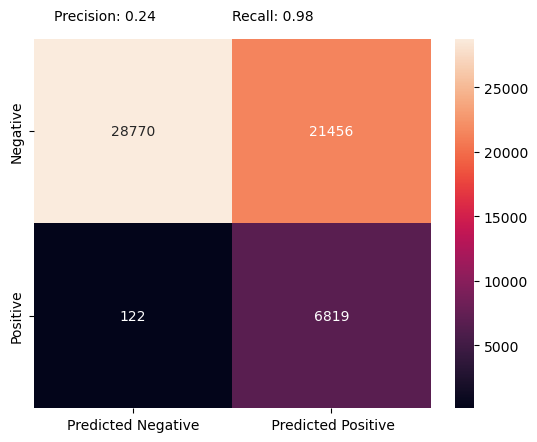

In [141]:
classification_report_and_confusion_matrix(y_val, y_proba_val, boundary=0.25)

              precision    recall  f1-score   support

           0      0.999     0.520     0.684     50226
           1      0.223     0.997     0.364      6941

    accuracy                          0.578     57167
   macro avg      0.611     0.758     0.524     57167
weighted avg      0.905     0.578     0.645     57167



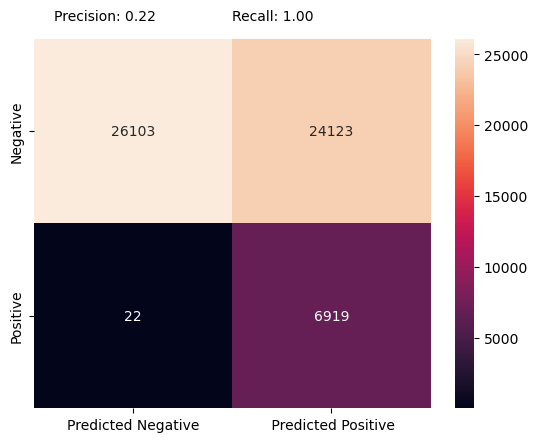

In [142]:
classification_report_and_confusion_matrix(y_val, y_proba_val, boundary=0.10)

              precision    recall  f1-score   support

           0      1.000     0.490     0.657     50226
           1      0.213     0.998     0.351      6941

    accuracy                          0.552     57167
   macro avg      0.606     0.744     0.504     57167
weighted avg      0.904     0.552     0.620     57167



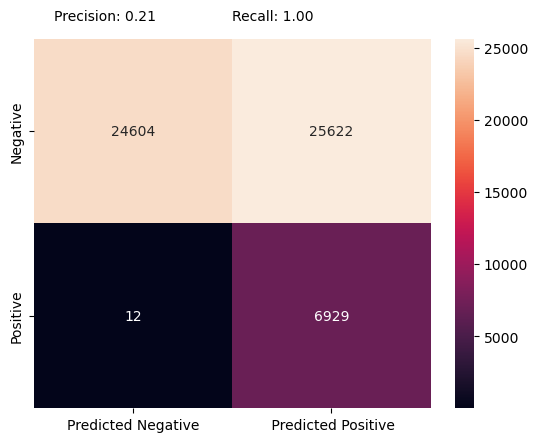

In [143]:
classification_report_and_confusion_matrix(y_val, y_proba_val, boundary=0.01)

              precision    recall  f1-score   support

           0      1.000     0.000     0.000     50226
           1      0.121     1.000     0.217      6941

    accuracy                          0.122     57167
   macro avg      0.561     0.500     0.108     57167
weighted avg      0.893     0.122     0.026     57167



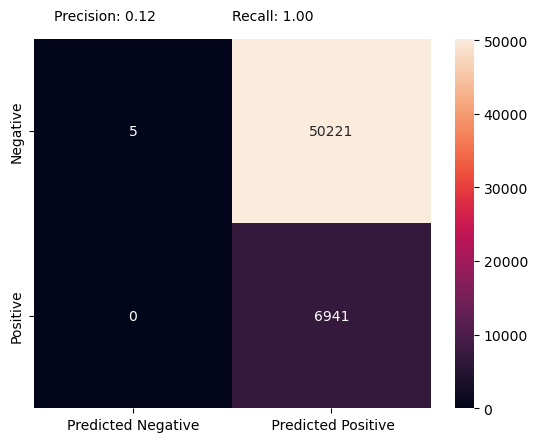

In [144]:
classification_report_and_confusion_matrix(y_val, y_proba_val, boundary=0.001)    # inutile

* Concludo che 0.01 è il valore migliore per la decision boundary (ho il numero minore di falsi negativi sul set di validazione, e la precision resta simile a prima)

# Previsione finale

In [176]:
X_test = test.drop("id", axis=1).values
X_train, y_train = _X_train, _y_train

BOUNDARY = 0.01

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

y_proba_test = lr.predict_proba(X_test)
y_pred_test = np.where(y_proba_test[:,1] > BOUNDARY, 1, 0)
Counter(y_pred_test)

Counter({0: 54983, 1: 72054})

In [180]:
test_result = pd.DataFrame({
    "id": test["id"],
    "Response": y_pred_test
})
test_result.to_csv("./dataset/test_with_response.csv", index=False)